# Tabular learning

## What is tabular learning

Tabular learning in reinforcement learning refers to methods that store and update value estimates for each state or state-action pair in a table. Algorithms like Q-learning and SARSA use this approach to iteratively refine value functions based on experience. It is effective for small state spaces but becomes impractical for large or continuous environments due to memory and computation constraints.

## Initial environment setup

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import typing as tt
import gymnasium as gym
import numpy as np
from collections import defaultdict, Counter
from utils.wrappers import RecordGif
from tensorboardX import SummaryWriter

## Frozen Lake

## V-Iteraction learning

### The agent

Now we are creating the agent responsible by learn how to navigate in the frozen lake to get the reward at the end of the map.

In [3]:
# SETTING UP SOME CONSTANTS FOR THE AGENT
GAMMA = 0.9

# DEFINING SOME TYPE ALIASES
State = int
Action = int
RewardKey = tt.Tuple[State, Action, State]
TransictionKey = tt.Tuple[State, Action]

class Agent:
    def __init__(self, env: gym.Env):
        self.env = env
        self.state, _ = env.reset()

        self.rewards: tt.Dict[RewardKey, float] = defaultdict(float)
        self.transictions: tt.Dict[TransictionKey, Counter] = defaultdict(Counter)
        self.values: tt.Dict[State, float] = defaultdict(float)

    def play_n_random_steps(self, n: int):
        for _ in range(n):
            action = self.env.action_space.sample()
            new_state, reward, done, trunc, _ = self.env.step(action)
            self.rewards[self.state, action, new_state] = float(reward)
            self.transictions[self.state, action][new_state] += 1

            if done or trunc:
                self.state, _ = self.env.reset()
            else:
                self.state = new_state


    def calc_action_value(self, state: State, action: Action) -> float:
        target_state_counts = self.transictions[state, action]
        total_visits = sum(target_state_counts.values())

        if total_visits == 0:
            return 0.0

        action_value = sum(
            target_state_counts[target_state] * (self.rewards[state, action, target_state] + GAMMA * self.values[target_state])
            for target_state in target_state_counts
        ) / total_visits

        return action_value


    def select_action(self, state: State) -> Action:
        action_values = [
            self.calc_action_value(state, action)
            for action in range(self.env.action_space.n)
        ]
        return np.argmax(action_values)
    
    
    def update_values(self):
        for state in range(self.env.observation_space.n):
            state_values = [
                self.calc_action_value(state, action)
                for action in range(self.env.action_space.n)
            ]
            self.values[state] = max(state_values)

    def play_episode(self, env: gym.Env) -> float:
        total_reward = 0.0
        state, _ = env.reset()
        
        while True:
            action = self.select_action(state)
            new_state, reward, done, trunc, _ = env.step(action)
            
            self.rewards[state, action, new_state] = float(reward)
            self.transictions[state, action][new_state] += 1

            total_reward += reward
            if done or trunc:
                return total_reward
            state = new_state


#### How does it work

in the `__init__` function, we need to initialize some dicts we will use to train our agent:
* `rewards`: This dict is responsible by store the reward for every agent step. We need to save the rewards so we can use it to find the path who will provide the higgest prize to the agent.
* `transictions`: We are also storing the state transictions and count the occurences as the agent needs this information to calculate the best path to the best reward.
* `values`: These are the state values and this is the result of the training and the data the agent will use to decide the acions it should take.

___

The `play_r_random_steps` is used to randomly play the environment and collect data for every step. This is the function we need to run to collect all the data we need to train the agent.

___

The `calc_action_value` function is one of the most important functions for Q-Value learning. The value of the action is the value the agent will use to select the action it has to perform in every situattion. The higgest the value action should the the action selected by the agent to do in any state.

$$
V(s, a) = \frac{1}{N(s, a)} \sum_{s'} T(s, a, s') \left[ R(s, a, s') + \gamma V(s') \right]
$$

where:
- $( V(s, a) )$ is the action value for action $( a )$ in state $( s )$.
- $( N(s, a) )$ is the total number of times action $( a )$ has been taken in state $( s )$.
- $( T(s, a, s') )$ is the count of transitions from state $( s )$ to state $( s' )$ after taking action $( a )$.
- $( R(s, a, s') )$ is the reward received after transitioning from state $( s )$ to state $( s' )$ with action $( a )$.
- $( \gamma )$ is the discount factor.
- $( V(s') )$ is the value of the next state $( s' )$.

The function calculates the expected value of the action by averaging the rewards and discounted future values over all possible next states.

___

The `select_action` function is responsible by iterate over all possible actions, calculate the action value and select the action with higgest value.

___

The `update_values` function is other of the most important functions, as it is responsible by calculate the value of the state, and update the `values` dictionary.

$$
V(s) = \max_{a} Q(s, a)
$$

where:
- $( V(s) )$ is the state value $( s )$.
- $( \max_{a} Q(s, a) )$ is the max action value $( a )$ in the state $( s )$.

The function iterates over all states and calculates the value of each state as the maximum value of all possible actions in that state.

___

The `play_episode` will play an episode of the game, using the trained action and state values calulated preciously by the training process.



### Traning the agent

In [4]:
ENV_NAME = 'FrozenLake-v1'

episode_trigger = lambda x: x % 250 == 0
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/v-iteraction/frozen-lake', name_prefix='traning', gif_length=500, episode_trigger=episode_trigger)

agent = Agent(env)
writer = SummaryWriter(logdir='runs/v-iteraction/frozen-lake', comment=f'-frozen-lake-q-value')

iteraction_number = 0
best_reward = 0.0

while True:
    iteraction_number += 1
    agent.play_n_random_steps(100)
    agent.update_values()

    reward = np.mean([agent.play_episode(env) for _ in range(20)])
    writer.add_scalar('reward', reward, iteraction_number)

    if reward > best_reward:
        print(f'Best reward updated: {best_reward:.3f} -> {reward:.3f}')
        best_reward = reward

    if reward > 0.80:
        print(f'Solved in {iteraction_number} iteractions!')
        break

writer.close()


Best reward updated: 0.000 -> 0.200
Best reward updated: 0.200 -> 0.500
Best reward updated: 0.500 -> 0.850
Solved in 11 iteractions!


Wow! V-Iteraction could learn how to solve the frozen lake really fast!

This is how it started!<br>
<img src="./gifs/v-iteraction/frozen-lake/traning-episode-0.gif" style="width: 250px">

This is the last recorded run!<br>
<img src="./gifs/v-iteraction/frozen-lake/traning-episode-250.gif" style="width: 250px">

Try again, but using only the trained agent

In [5]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/v-iteraction/frozen-lake', name_prefix='model', gif_length=500)

agent.play_episode(env)

env.close()

<img src="./gifs/v-iteraction/frozen-lake/model-episode-0.gif">

Even with the complexity of the environment who drift the step some times, it could perform really well

## Q-Iteraction learning

### The agent

In [ ]:
# SETTING UP SOME CONSTANTS FOR THE AGENT
GAMMA = 0.9

# DEFINING SOME TYPE ALIASES
State = int
Action = int
RewardKey = tt.Tuple[State, Action, State]
TransictionKey = tt.Tuple[State, Action]

class Agent:
    def __init__(self, env: gym.Env):
        self.env = env
        self.state, _ = env.reset()

        self.rewards: tt.Dict[RewardKey, float] = defaultdict(float)
        self.transictions: tt.Dict[TransictionKey, Counter] = defaultdict(Counter)
        self.values: tt.Dict[TransictionKey, float] = defaultdict(float)

    def play_n_random_steps(self, n: int):
        for _ in range(n):
            action = self.env.action_space.sample()
            new_state, reward, done, trunc, _ = self.env.step(action)
            self.rewards[self.state, action, new_state] = float(reward)
            self.transictions[self.state, action][new_state] += 1

            if done or trunc:
                self.state, _ = self.env.reset()
            else:
                self.state = new_state


    def select_action(self, state: State) -> Action:
        action_values = [
            self.values[state, action]
            for action in range(self.env.action_space.n)
        ]
        return np.argmax(action_values)
    
    
    def update_values(self):
        for state in range(self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                target_state_counts = self.transictions[state, action]
                total_visits = sum(target_state_counts.values())

                if total_visits == 0:
                    continue

                action_value = 0.0
                for target_state, count in target_state_counts.items():
                    best_target_action = self.select_action(target_state)
                    value = self.rewards[state, action, target_state] + GAMMA * self.values[target_state, best_target_action]
                    action_value += (count/total_visits) * value

                self.values[state, action] = action_value


    def play_episode(self, env: gym.Env) -> float:
        total_reward = 0.0
        state, _ = env.reset()
        
        while True:
            action = self.select_action(state)
            new_state, reward, done, trunc, _ = env.step(action)
            
            self.rewards[state, action, new_state] = float(reward)
            self.transictions[state, action][new_state] += 1

            total_reward += reward
            if done or trunc:
                return total_reward
            state = new_state

### Training the agent

In [6]:
ENV_NAME = 'FrozenLake-v1'

episode_trigger = lambda x: x % 250 == 0
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/q-iteraction/frozen-lake', name_prefix='traning', gif_length=500, episode_trigger=episode_trigger)

agent = Agent(env)
writer = SummaryWriter(logdir='runs/q-iteraction/frozen-lake', comment=f'-frozen-lake-q-value')

iteraction_number = 0
best_reward = 0.0

while True:
    iteraction_number += 1
    agent.play_n_random_steps(100)
    agent.update_values()

    reward = np.mean([agent.play_episode(env) for _ in range(20)])
    writer.add_scalar('reward', reward, iteraction_number)

    if reward > best_reward:
        print(f'Best reward updated: {best_reward:.3f} -> {reward:.3f}')
        best_reward = reward

    if reward > 0.80:
        print(f'Solved in {iteraction_number} iteractions!')
        break

writer.close()


Best reward updated: 0.000 -> 0.100
Best reward updated: 0.100 -> 0.150
Best reward updated: 0.150 -> 0.250
Best reward updated: 0.250 -> 0.400
Best reward updated: 0.400 -> 0.500
Best reward updated: 0.500 -> 0.650
Best reward updated: 0.650 -> 0.800
Best reward updated: 0.800 -> 0.850
Solved in 81 iteractions!


Q-Iteraction could learn how to solve the frozen lake fast as well!

This is how it started!<br>
<img src="./gifs/q-iteraction/frozen-lake/traning-episode-0.gif" style="width: 250px">

This is the last recorded run!<br>
<img src="./gifs/q-iteraction/frozen-lake/traning-episode-2500.gif" style="width: 250px">

now I would like to try it one more time using the trained agent

In [9]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/q-iteraction/frozen-lake', name_prefix='model', gif_length=500)

agent.play_episode(env)

env.close()

<img src="./gifs/q-iteraction/frozen-lake/model-episode-0.gif" style="width: 250px">

## Q-Learning

### The agent

In [4]:
GAMMA = 0.9
ALPHA = 0.2

State = int
Action = int
ValuesKey = tt.Tuple[State, Action]

class Agent:

    def __init__(self, env: gym.Env):
        self.env = env
        self.state, _ = env.reset()

        self.values: tt.Dict[ValuesKey] = defaultdict(float)

    
    def sample_env(self) -> tt.Tuple[State, Action, float, State]:
        action = self.env.action_space.sample()
        old_state = self.state
        new_state, reward, done, trunc, _ = self.env.step(action)
        if done or trunc:
            self.state, _ = self.env.reset()
        else:
            self.state = new_state
        return old_state, action, reward, new_state
    

    def get_best_action_and_value(self, state: State) -> tt.Tuple[Action, float]:
        best_action, best_value = None, float('-inf')
        for action in range(self.env.action_space.n):
            value = self.values[state, action]
            if value > best_value:
                best_value = value
                best_action = action
        return best_action, best_value
    

    def update_values(self, state: State, action: Action, reward: float, new_state: State):
        _, best_value = self.get_best_action_and_value(new_state)
        new_value = reward + GAMMA * best_value
        value = self.values[state, action]
        self.values[state, action] = value * (1-ALPHA) + new_value * ALPHA

    
    def play_episode(self, env: gym.Env) -> float:
        total_reward = 0.0
        state, _ = env.reset()

        while True:
            action, _ = self.get_best_action_and_value(state)
            new_state, reward, done, trunc, _ = env.step(action)
            total_reward += reward
            if done or trunc:
                return total_reward
            state = new_state


### Training the agent

In [ ]:
ENV_NAME = 'FrozenLake-v1'

episode_trigger = lambda x: x % 50000 == 0
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/q-value/frozen-lake', name_prefix='traning', gif_length=500, episode_trigger=episode_trigger)

test_env = gym.make(ENV_NAME)

agent = Agent(env)
writer = SummaryWriter(logdir='runs/q-value/frozen-lake', comment=f'-frozen-lake-q-value')

iteraction_number = 0
best_reward = 0.0

while True:
    iteraction_number += 1
    state, action, reward, new_state = agent.sample_env()
    agent.update_values(state, action, reward, new_state)

    reward = np.mean([agent.play_episode(test_env) for _ in range(20)])
    writer.add_scalar('reward', reward, iteraction_number)

    if reward > best_reward:
        print(f'Best reward updated: {best_reward:.3f} -> {reward:.3f}')
        best_reward = reward

    if reward > 0.80:
        print(f'Solved in {iteraction_number} iteractions!')
        break

writer.close()


0
3
2
3
3
1
2
2
1
2
1
2
0
2
1
0
1
0
0
2
0
3
0
3
2
2
2
0
2
0
1
1
2
2
1
0
0
3
1
3
0
0
0
2
0
1
0
2
2
3
0
1
3
2
0
3
0
2
3
0
1
1
3
1
1
0
3
0
0
1
3
1
3
2
3
1
0
0
2
2
3
0
2
1
3
2
1
0
1
0
1
1
3
2
0
3
2
3
0
1
0
3
2
0
1
0
1
2
1
3
3
2
2
0
0
0
2
0
3
2
2
1
1
1
1
1
2
0
3
1
2
0
2
1
0
0
3
1
0
1
2
1
3
0
0
3
2
0
0
2
2
1
1
1
0
1
2
1
0
0
2
2
2
0
3
0
0
3
3
1
0
2
2
1
2
1
0
2
1
0
3
1
3
2
1
2
3
0
1
1
0
1
1
2
3
2
3
3
3
1
2
2
3
2
1
2
3
0
1
2
2
3
1
3
0
0
0
3
3
0
3
2
3
1
1
3
0
1
1
2
1
1
1
2
3
3
0
1
1
3
1
0
0
3
0
3
2
0
1
0
1
0
2
1
0
2
2
0
1
3
3
3
1
1
3
2
1
3
0
2
1
2
1
0
1
3
0
0
2
2
3
2
3
3
2
2
0
0
0
3
2
1
3
2
1
2
1
3
1
0
0
2
1
3
2
3
3
1
3
2
3
2
0
1
1
2
2
3
0
2
1
3
1
3
2
1
3
3
2
3
3
1
0
3
0
1
1
2
2
3
0
0
0
3
2
0
3
0
2
0
2
0
1
2
3
2
3
1
0
1
2
0
1
0
2
3
2
3
3
2
2
1
0
0
3
2
2
3
2
0
1
2
0
3
3
1
1
3
3
3
0
0
3
1
0
1
3
3
0
3
2
0
0
2
0
2
2
1
2
3
3
2
2
1
2
2
3
3
2
2
0
0
2
2
2
0
3
2
3
1
2
2
3
3
0
2
0


In [7]:
writer.close()

KeyboardInterrupt: 

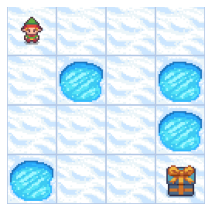

In [9]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordGif(env, './gifs/temp', name_prefix='traning', gif_length=500)

agent = Agent(env)
while True:
    agent.sample_env()


In [10]:
env.close()